In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<font size=6>
    Correlation study
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>
<font color='red' size=5>
    The show so far ... 
</font>


In [2]:
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [20]:
cols = list(map(str, range(1,21)))

In [27]:
def get_corr_feature_drop_1(df_corr,threshold=0.95):
    # from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
    # also seen in https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    """
    Basic, minimal feature drop function: 
    blindly selects correlations to drop based on correlation
    """
    # Create correlation matrix, with abs since interested only in magnitude
    #df_corr = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    #df.drop(to_drop, axis=1, inplace=True)

    return cols_to_drop

In [54]:
np.abs(np.random.normal(loc=0.75,scale=0.25, size=[20])%1.1)

array([0.33739681, 0.99845119, 0.62000924, 0.72394956, 0.98151164,
       0.28110948, 0.03583807, 0.89488157, 0.73275171, 0.7294638 ,
       0.43010819, 0.6548725 , 0.67473604, 0.67273599, 0.34042704,
       0.65391838, 0.66084369, 0.46570534, 0.87271478, 0.76843275])

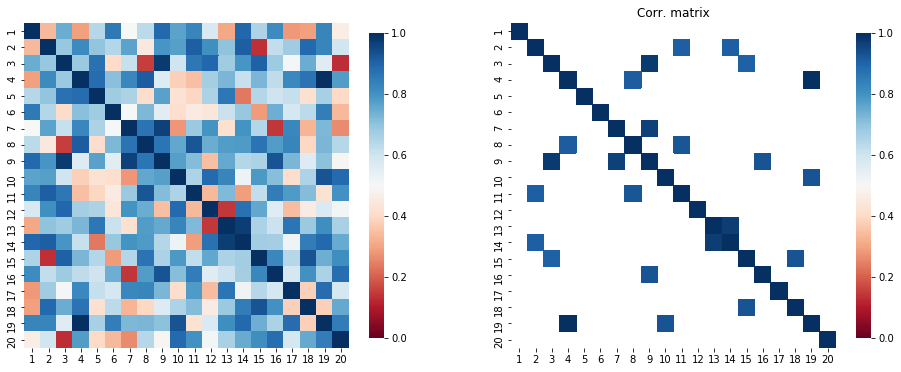

In [87]:
corr_matrix = np.abs(np.random.normal(loc=0.8,scale=0.24, size=[20,20])%1.05)
#corr_matrix = np.random.rand(20,20)
np.clip(0,1, corr_matrix)
np.fill_diagonal(corr_matrix,1)
corr_matrix = (corr_matrix + corr_matrix.T)/2

df_corr = pd.DataFrame(data=corr_matrix, index=cols, columns=cols)



fig, ax = plt.subplots(1,2, figsize=(16,8))
ax = ax.reshape(2)

sns.heatmap(df_corr, cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[0]);

sns.heatmap(df_corr.where(df_corr > 0.9), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[1]);


plt.title(f'Corr. matrix');

In [94]:
threshold = 0.9

In [95]:
get_corr_feature_drop_1(df_corr,threshold)

['8', '9', '11', '14', '15', '16', '18', '19']

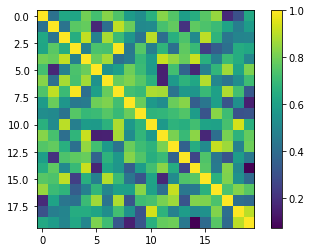

In [75]:
plt.imshow(corr_matrix)
cb =plt.colorbar()

In [101]:
df_corr.loc['1','5'] = 1.0
df_corr.loc['5','1'] = 1.0

In [102]:
df_upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

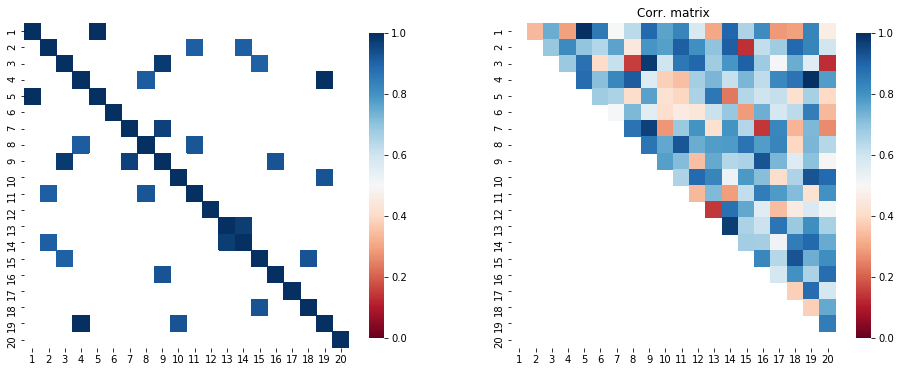

In [103]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax = ax.reshape(2)

sns.heatmap(df_upper, cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[1]);

sns.heatmap(df_corr.where(df_corr > 0.9), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[0]);


plt.title(f'Corr. matrix');

In [121]:
df_targ_corr = np.abs(np.random.normal(loc=0.5,scale=0.24, size=[20,1])%1.05)
np.clip(0,1, df_targ_corr)
df_targ_corr = pd.DataFrame(data=df_targ_corr.T, index=['targ'], columns=cols)

In [122]:
df_targ_corr.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
targ,0.767172,0.500187,0.372487,0.695082,0.572712,0.275609,0.464009,0.546802,0.423983,0.395407,0.427922,0.393207,0.323214,0.295114,0.046772,0.448215,0.600166,0.493147,0.158992,0.627863


**Goal** drop the highly correlated features but keep a replacement which retains much of the information

**The problems:**
1. features are blindly dropped
* no chekcing to see if the droppable feature has better or worse correlation with the target feature
* no checking to see if the droppable feature is the replacement for another droppable feature (potentially dropping both features!)


**ToDo**
For each dropped col, 
1. check whether it's in the replacements for other cols
    * if so, don't drop
2. check it's replacements
    * drop the col with the lesser correlation with the target feature
    
Examples:
1. one col has one replacer
    * the col is not in the replacements set
    * the replacer only shows up once in the replacements set
    * get the column associated with min(col.corr(targ), replacer.corr(targ))


In [131]:
discardables, replaceables, replaceable = [], [], []
for column in df_upper.columns:
    # For each column, see if there are any highly correlated rows
    #   if so, save the current col name.
    if any(df_upper[column] > threshold):
        discardables.append(column)
        replacers = df_corr[df_upper[column]>threshold].index.tolist()        
        replaceable += replacers
        replaceables.append(replacers)
replaceable = sorted(list(set(replaceable)))
replace_dict = dict(zip(discardables,replaceables))

for column in discardables:
    # For each column, see if there are any highly correlated rows
    #   if so, save the current col name.
    if column in replaceable:
        print('\tsave it')
    else:
        print('drop it')

drop it
	save it
	save it
drop it
drop it
	save it
drop it
drop it
drop it


In [115]:
cols_to_drop = get_corr_feature_drop_1(df_corr,threshold)

In [116]:
for col in cols_to_drop:
    print(col,df_corr[df_upper[col]>threshold].index.tolist())

5 ['1']
8 ['4']
9 ['3', '7']
11 ['2', '8']
14 ['2', '13']
15 ['3']
16 ['9']
18 ['15']
19 ['4', '10']


In [132]:
x = df_corr.values

In [133]:
type(x)

numpy.ndarray

In [134]:
keep_idx = np.ones(x.shape[0], dtype=bool)
for i in range(x.shape[0]):
    # Create the mask from the kept indices
    mask = np.ix_(keep_idx, keep_idx)
    # Get the number of correlations above a threshold.
    counts = np.sum(corr[mask] > threshold, axis=0)
    print(counts.shape)
    if max(counts) == 0:
        break
    # Get the worst offender and work out what the
    # original index was
    idx = np.where(keep_idx)[0][np.argmax(counts)]
    # Update mask
    keep_idx[idx] = False

NameError: name 'corr' is not defined